In [372]:
#imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns


from mrmr import mrmr_regression

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
torch.manual_seed(4000)

##### data preparation

In [373]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [374]:
#remove missing values
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [375]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

#train 0.8
#test 0.2

#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

In [376]:
x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())

##### NN model class, train and evaluate functions

In [377]:
#convert, pandas to loader
def make_loader(X,y,batch):
    if not isinstance(X, pd.DataFrame):
        try:
            X = pd.DataFrame(X)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y, pd.Series):
        try:
            y = pd.Series(y)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
            
    x_tensor=torch.tensor(X.values, dtype=torch.float32)
    y_tensor=torch.tensor(y.values, dtype=torch.float32)
    set_object=TensorDataset(x_tensor,y_tensor)
    loader_object=DataLoader(dataset=set_object,batch_size=batch)
    return loader_object

In [378]:
#NN class
class NeuralNetwork(nn.Module):
    def __init__(self,input_size):
        super(NeuralNetwork,self).__init__()
        
        self.linear1=nn.Linear(input_size,4)
        self.activation1=nn.ReLU()
        self.linear2=nn.Linear(4,4)
        self.activation2=nn.ReLU()
        self.linear3=nn.Linear(4,1)
        
    def forward(self,x):
        x=self.linear1(x)
        x=self.activation1(x)
        x=self.linear2(x)
        x=self.activation2(x)
        x=self.linear3(x)
        return x

In [379]:
#evaluate once
def evaluate(Loader, model, loss_fn):
    loss_sum=0
    with torch.no_grad():
        for batch, (X,y) in enumerate(Loader):
            pred=model(X)
            loss=loss_fn(pred,y.unsqueeze(1))
            loss_sum+=loss.item()
            
    loss_sum/=len(Loader)
    
    return loss_sum

In [380]:
#train and store all errors =)
def train_fn(TrainLoader, TestLoader, model, loss_fn, optimizer,epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    model.train() 
    
    for epoch in range(epochs):
        #train for every example in the dataloader
        for X_train,y_train in TrainLoader:
            
            pred_train=model(X_train)
            loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
    return model, train_loss_epochs, test_loss_epochs

In [381]:
#train and not store all errors, i will use this one on the building of the tables, will speed up things...
def train_fn_no_loss(TrainLoader, model, loss_fn, optimizer,epochs):
    model.train() 
    for epoch in range(epochs):
        #train for every example in the dataloader
        for X_train,y_train in TrainLoader:
            
            pred_train=model(X_train)
            loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
    return model

In [382]:
def train_one_epoch(TrainLoader, model, loss_fn, optimizer):
    model.train() 
    #train for every example in the dataloader
    for X_train,y_train in TrainLoader:
            
        pred_train=model(X_train)
        loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    return model

In [403]:
''' #other implementation is better!
class EarlyStopper:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.last_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.last_loss:  # Spike detection
            pass  # Do nothing if a spike is detected
        else:
            self.counter += 1  # Increment if no improvement or no spike
            if self.counter >= self.patience:
                return True
        
        self.last_loss = validation_loss
        return False
'''

" #other implementation is better!\nclass EarlyStopper:\n    def __init__(self, patience, min_delta):\n        self.patience = patience\n        self.min_delta = min_delta\n        self.counter = 0\n        self.best_loss = float('inf')\n        self.last_loss = float('inf')\n\n    def early_stop(self, validation_loss):\n        if validation_loss < self.best_loss - self.min_delta:\n            self.best_loss = validation_loss\n            self.counter = 0\n        elif validation_loss > self.last_loss:  # Spike detection\n            pass  # Do nothing if a spike is detected\n        else:\n            self.counter += 1  # Increment if no improvement or no spike\n            if self.counter >= self.patience:\n                return True\n        \n        self.last_loss = validation_loss\n        return False\n"

In [404]:
class EarlyStopper: #NOVOOOOOOO
    def __init__(self, patience=100, min_delta=0.0005, degradation_allowance=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.degradation_allowance = degradation_allowance
        self.counter = 0
        self.best_score = float('inf')
        self.best_epoch = -1

    def early_stop(self, epoch, validation_loss):
        if validation_loss < self.best_score - self.min_delta:
            self.best_score = validation_loss
            self.best_epoch = epoch
            self.counter = 0
        elif validation_loss > self.best_score + self.degradation_allowance:
            # If the validation loss is worse than the best score by a certain allowance, stop.
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [405]:
#train and store all errors =)
def train_criterion(TrainLoader, TestLoader, model, loss_fn, optimizer,max_epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    model.train() 
    
    early_stopper = EarlyStopper(patience=100, min_delta=0.0005)
    
    for epoch in range(max_epochs):
        #train for every example in the dataloader
        model=train_one_epoch(TrainLoader=TrainLoader, model=model, loss_fn=loss_fn, optimizer=optimizer)
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
        if early_stopper.early_stop(epoch=epoch,validation_loss=loss_test_curr_epoch):             
            break
        
    return model, train_loss_epochs, test_loss_epochs

In [406]:
def ini_model(input,epochs=200):
    torch.manual_seed(2000)
    model=NeuralNetwork(input_size=input)
    loss_fn=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),
                         lr=0.001,
                         weight_decay=0.0008)
    return model,loss_fn,optimizer,epochs

##### NN Simple loss plot example

In [346]:
train_loader=make_loader(X=x_train,y=y_train,batch=1000)
test_loader=make_loader(X=x_test,y=y_test,batch=1000)

model,loss_fn,optimizer,epochs=ini_model(input=401)

In [344]:
model, train_loss, test_loss=train_fn(TrainLoader=train_loader,
                                      TestLoader=test_loader, 
                                      model=model, 
                                      loss_fn=loss_fn, 
                                      optimizer=optimizer,
                                      epochs=6000)

In [363]:
model, train_loss, test_loss=train_criterion(TrainLoader=train_loader,
                                             TestLoader=test_loader,
                                             model=model,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer,
                                             max_epochs=6000)

(0.0, 0.05)

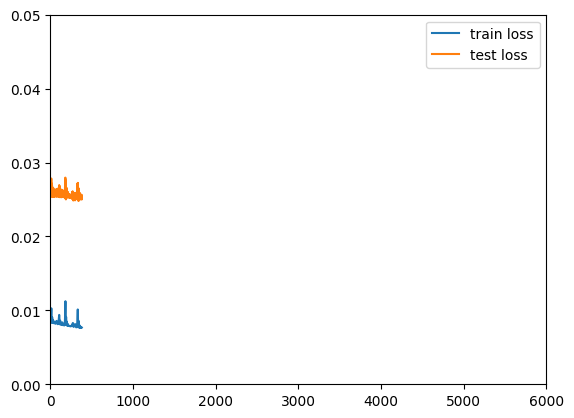

In [364]:
plt.plot(np.arange(len(train_loss)),train_loss,label='train loss')
plt.plot(np.arange(len(test_loss)),test_loss,label='test loss')
plt.legend()
plt.xlim(000,6000)
plt.ylim(0.0,0.05)

##### NN permutation importance functions

In [371]:
#permutation importance from scikitlearn internally uses the predict function and checks for the presence
#of the fit function. if i feed my pytorch model inside a wrapper scikitlearn allows me tu use it's function =)
class PyTorchRegressorWrapper:
    def __init__(self, model):
        model = model

    def fit(self, X, y):
        #this function only needs to exhist to fulfill API contract with scikitlearn
        pass

    def predict(self, X):
        model.eval()
        with torch.no_grad():
            #convert to numpy as needed
            if isinstance(X, pd.DataFrame):
                X = X.to_numpy()

            X_tensor = torch.tensor(X, dtype=torch.float32)
            predictions = model(X_tensor).numpy()
        return predictions

In [399]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_loss(X_train,y_train,k_folds):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((x_train.shape[1],kfold.n_splits))

    train_loss_fold=[[],[],[],[],[]]
    val_loss_fold=[[],[],[],[],[]]
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=1000)
        test_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=1000)

        model,loss_fn,optimizer,epochs=ini_model(input=401) #epochs defined inside function
        '''
        model, train_loss_fold[fold], val_loss_fold[fold]=train_fn(TrainLoader=train_loader_fold,
                                                                   TestLoader=test_loader_fold, 
                                                                   model=model, 
                                                                   loss_fn=loss_fn, 
                                                                   optimizer=optimizer,
                                                                   epochs=epochs)
        '''
        
        model, train_loss_fold[fold], val_loss_fold[fold]=train_criterion(TrainLoader=train_loader_fold,
                                                                            TestLoader=test_loader_fold,
                                                                            model=model,
                                                                            loss_fn=loss_fn,
                                                                            optimizer=optimizer,
                                                                            max_epochs=6000)
        
        # pass model trough wrapper
        model_wrapper = PyTorchRegressorWrapper(model=model)

        # permutation importance with the wrapper instance
        results = permutation_importance(model_wrapper,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances, train_loss_fold, val_loss_fold


In [367]:
#this function returns the indexes to sice the n most important features
def perm_imp_get_topn_indexes(perm_imp_output,top_n):
    
    best_n=perm_imp_output.sort_values().head(top_n).index
    
    return best_n

In [368]:
def build_table(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    for features in np.arange(401,30,-step):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train=x_train[important_idx.sort_values()]
        x_test=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=32)
            val_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=32)

            model,loss_fn,optimizer,epochs=ini_model(input=features)#epochs defined inside function
            
            model=train_fn_no_loss(TrainLoader=train_loader_fold, 
                                   model=model, 
                                   loss_fn=loss_fn, 
                                   optimizer=optimizer,
                                   epochs=epochs)
            
            train_loss_single_fold=evaluate(Loader=train_loader_fold, model=model, loss_fn=loss_fn)
            val_loss_single_fold=evaluate(Loader=val_loader_fold, model=model, loss_fn=loss_fn)
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        
        train_loader=make_loader(X=x_train,y=y_train,batch=32)
        test_loader=make_loader(X=x_test,y=y_test,batch=32)

        model,loss_fn,optimizer,epochs=ini_model(input=features) #definedinside function
        model=train_fn_no_loss(TrainLoader=train_loader, 
                                    model=model, 
                                    loss_fn=loss_fn, 
                                    optimizer=optimizer,
                                    epochs=epochs)
                
        train_loss=evaluate(Loader=train_loader, model=model, loss_fn=loss_fn)
        val_loss=evaluate(Loader=test_loader, model=model, loss_fn=loss_fn)
        
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                val_loss]
            
    return stored

In [369]:
#check consistency by intersection
def check_intersections(df,top_n):
    col=df.columns
    matrix=np.zeros((5,5),dtype=float)
    top_idx=[]
    for i in range(1,6):
        top_idx.append(set(perm_imp_get_topn_indexes(perm_imp_output=df['fold'+str(i)],top_n=top_n)))
        
    for i in range(0,5):
        for j in range(0,5):
            if j<=j:
                intersec_acc=len(top_idx[i] & top_idx[j])/top_n
                matrix[i,j]=intersec_acc
                matrix[j,i]=intersec_acc
    #eturn top_idx
    return pd.DataFrame(matrix, index=col, columns=col)

##### NN result table example (perm import)

In [286]:
importances,train_loss_list,val_loss_list=permutation_importance_loss(X_train=x_train,
                                                                      y_train=y_train,
                                                                      k_folds=5)

In [287]:
importance_rank=pd.DataFrame(importances).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank=importance_rank_named.median(axis=1) #using median is more robust to outliers 



In [288]:
#check consistency by intersection
check_intersections(importance_rank_named,100)

,fold1,fold2,fold3,fold4,fold5
fold1,1.00,0.63,0.72,0.56,0.58
fold2,0.63,1.00,0.79,0.62,0.64
fold3,0.72,0.79,1.00,0.54,0.62
fold4,0.56,0.62,0.54,1.00,0.77
fold5,0.58,0.64,0.62,0.77,1.00


In [289]:
table = build_table(x_train=x_train,
                    y_train=y_train,
                    x_test=x_test,
                    y_test=y_test,
                    step=10,
                    perm_imp_array=importance_overall_rank,
                    k_folds=5)

In [588]:
#write in memory...
df=pd.DataFrame(table)
dir_path='C:\\Users\\lucas\\Downloads'

os.makedirs(dir_path,exist_ok=True)
file_path=os.path.join(dir_path,'table_dataframe_NN_permI')
df.to_csv(file_path, index=False)

In [290]:
table

,train mse,train std,val mse,val std,calibration mse,test mse
401,0.074907,0.004326,0.122152,0.018283,0.067703,0.082295
391,0.080472,0.047697,0.120779,0.049833,0.046815,0.053814
381,0.303774,0.115985,0.321382,0.117559,0.067455,0.066365
371,0.070213,0.011346,0.100327,0.015786,0.063324,0.072470
361,0.197555,0.112104,0.257565,0.119483,0.104394,0.108094
351,0.065098,0.004508,0.097679,0.015487,0.058598,0.098878
341,0.116072,0.015678,0.134081,0.054136,0.096169,0.066972
331,0.066316,0.010215,0.110091,0.017802,0.060990,0.090918
321,0.063699,0.005981,0.098976,0.014886,0.061401,0.073947
311,0.058611,0.006199,0.086542,0.012405,0.061298,0.059773


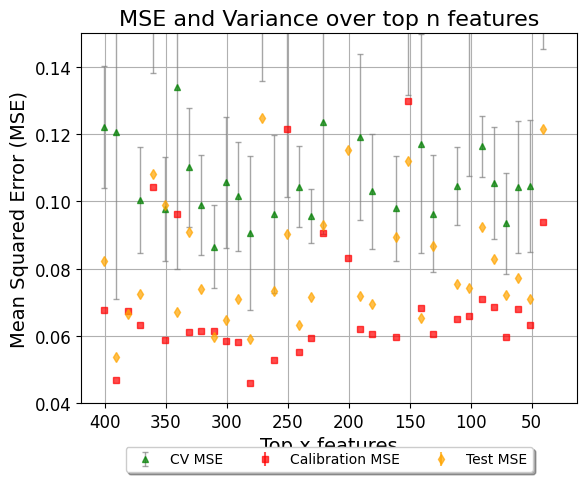

In [349]:
#plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['val mse'][::-1], yerr=table['val std'][::-1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration mse'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test mse'][::-1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.04, 0.15)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

In [390]:
topX=281
important_idx=perm_imp_get_topn_indexes(perm_imp_output=importance_overall_rank,
                                                top_n=topX)
    
x_train_important=x_train[important_idx.sort_values()]
x_test_important=x_test[important_idx.sort_values()]

train_loader_important=make_loader(x_train_important,y_train,32)
test_loader_important=make_loader(x_test_important,y_test,32)

model,loss_fn,optimizer,epochs=ini_model(input=topX,epochs=200)
model, train_loss, test_loss=train_fn(TrainLoader=train_loader_important,
                                      TestLoader=test_loader_important, 
                                      model=model, 
                                      loss_fn=loss_fn, 
                                      optimizer=optimizer,
                                      epochs=epochs)

Text(0, 0.5, 'MSE')

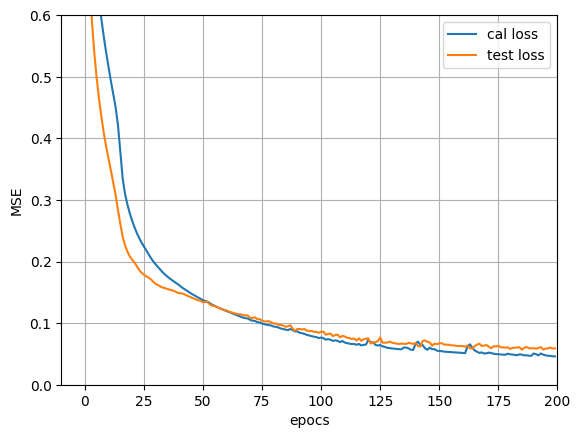

In [391]:
plt.plot(np.arange(epochs),train_loss,label='cal loss')
plt.plot(np.arange(epochs),test_loss,label='test loss')
plt.legend()
plt.xlim(-10,200)
plt.ylim(0,0.6)
plt.grid()
plt.xlabel('epocs')
plt.ylabel('MSE')

##### NN permutation importance example, with plotting of the kfolds loss

In [407]:
importances,train_loss_list,val_loss_list=permutation_importance_loss(X_train=x_train,
                                                                      y_train=y_train,
                                                                      k_folds=5)


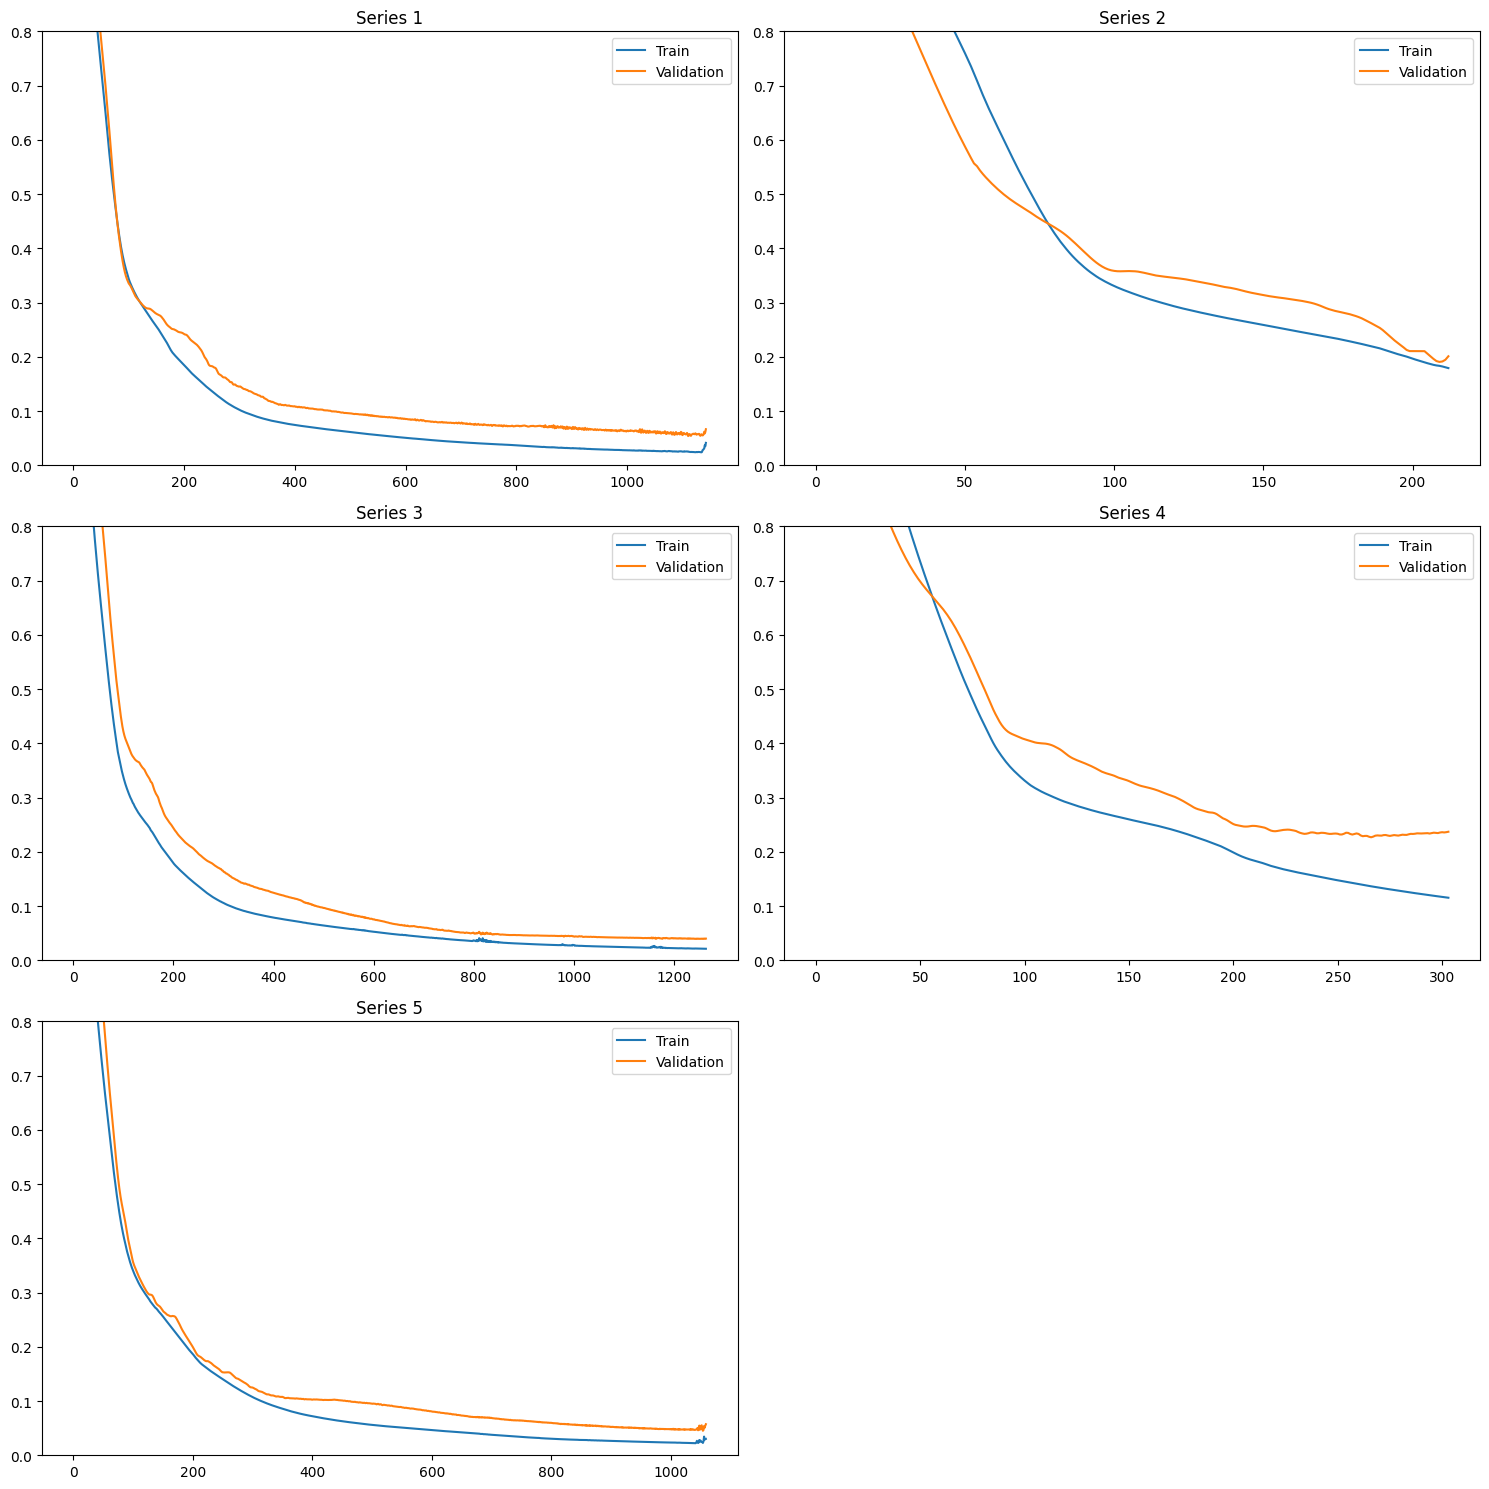

In [408]:
#loss plots on different folds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns

# flat so i can use indexing
axs_flat = axs.flatten()

for i in range(5):
    # Plot on subplot i
    axs_flat[i].plot(np.arange(len(train_loss_list[i])), train_loss_list[i], label='Train')
    axs_flat[i].plot(np.arange(len(val_loss_list[i])), val_loss_list[i], label='Validation')
    axs_flat[i].legend()
    axs_flat[i].set_title(f'Series {i+1}')
    axs_flat[i].set_ylim([0, 0.8])

# Hide the last subplot as it's unused
axs_flat[-1].axis('off')

plt.tight_layout()
plt.show()

(0.0, 0.75)

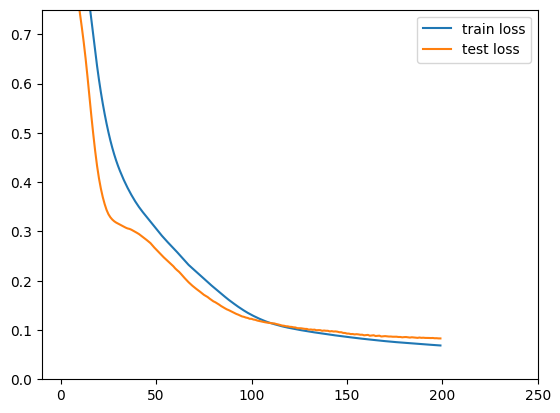

In [121]:
#loss for top x important
valores=81
important_idx=perm_imp_get_topn_indexes(perm_imp_output=importance_overall_rank,
                                                top_n=valores)
    
x_train=x_train[important_idx.sort_values()]
x_test=x_test[important_idx.sort_values()]
model,loss_fn,optimizer,epochs=ini_model(input=valores) #definedinside function
train_loader=make_loader(X=x_train,y=y_train,batch=32)
test_loader=make_loader(X=x_test,y=y_test,batch=32)

model, train_loss, test_loss=train_fn(TrainLoader=train_loader,
                                      TestLoader=test_loader, 
                                      model=model, 
                                      loss_fn=loss_fn, 
                                      optimizer=optimizer,
                                      epochs=epochs)

plt.plot(np.arange(epochs),train_loss,label='train loss')
plt.plot(np.arange(epochs),test_loss,label='test loss')
plt.legend()
plt.xlim(-10,250)
plt.ylim(0,0.75)

##### pls perm_imp functions

In [21]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_pls(X_train,y_train,k_folds,latent_variables):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((x_train.shape[1],kfold.n_splits))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train_fold,y_train_fold)
        
        results = permutation_importance(pls,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances

In [22]:
def build_table_pls(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds,latent_variables):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    for features in np.arange(401,30,-step):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train=x_train[important_idx.sort_values()]
        x_test=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            pls=PLSRegression(n_components=latent_variables)
            pls.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,pls.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,pls.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        

        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train,y_train)
        
        train_loss=mean_squared_error(y_train,pls.predict(x_train))
        test_loss=mean_squared_error(y_test,pls.predict(x_test))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss]
            
    return stored

##### pls perm_imp evalutation

In [278]:
components_used=[]
train_list=[]
test_list=[]
for i in np.arange(1,50,1):
    pls=PLSRegression(n_components=i)
    pls.fit(x_train,y_train)
    pred_train=pls.predict(x_train)
    pred_test=pls.predict(x_test)
    train_mse=mean_squared_error(y_train,pred_train)
    test_mse=mean_squared_error(y_test,pred_test)
    train_list.append(train_mse)
    test_list.append(test_mse)
    components_used.append(i)

Text(0, 0.5, 'MSE')

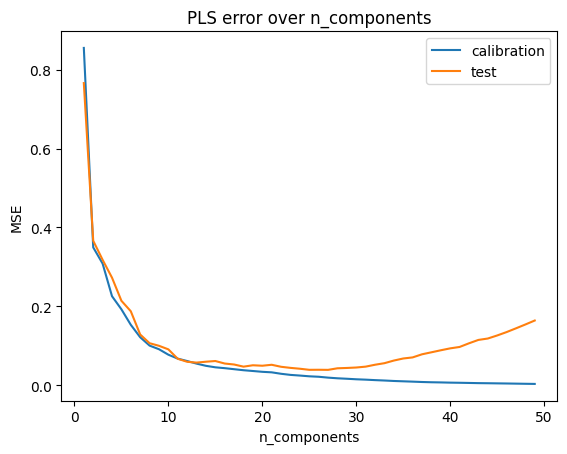

In [279]:
plt.plot(components_used,train_list,label='calibration')
plt.plot(components_used,test_list,label='test')
plt.legend()
plt.title('PLS error over n_components')
plt.xlabel('n_components')
plt.ylabel('MSE')

In [111]:
importances_pls=permutation_importance_pls(X_train=x_train,
                                           y_train=y_train,
                                           k_folds=5,
                                           latent_variables=15)

In [112]:
importance_rank=pd.DataFrame(importances_pls).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank=importance_rank_named.median(axis=1) #using median is more robust to outliers 

In [113]:
check_intersections(importance_rank_named,200)

,fold1,fold2,fold3,fold4,fold5
fold1,1.000,0.685,0.710,0.730,0.685
fold2,0.685,1.000,0.585,0.690,0.610
fold3,0.710,0.585,1.000,0.750,0.865
fold4,0.730,0.690,0.750,1.000,0.785
fold5,0.685,0.610,0.865,0.785,1.000


In [105]:
table = build_table_pls(x_train=x_train,
                        y_train=y_train,
                       x_test=x_test,
                       y_test=y_test,
                       step=1,
                       perm_imp_array=a,
                       k_folds=5,
                       latent_variables=15)

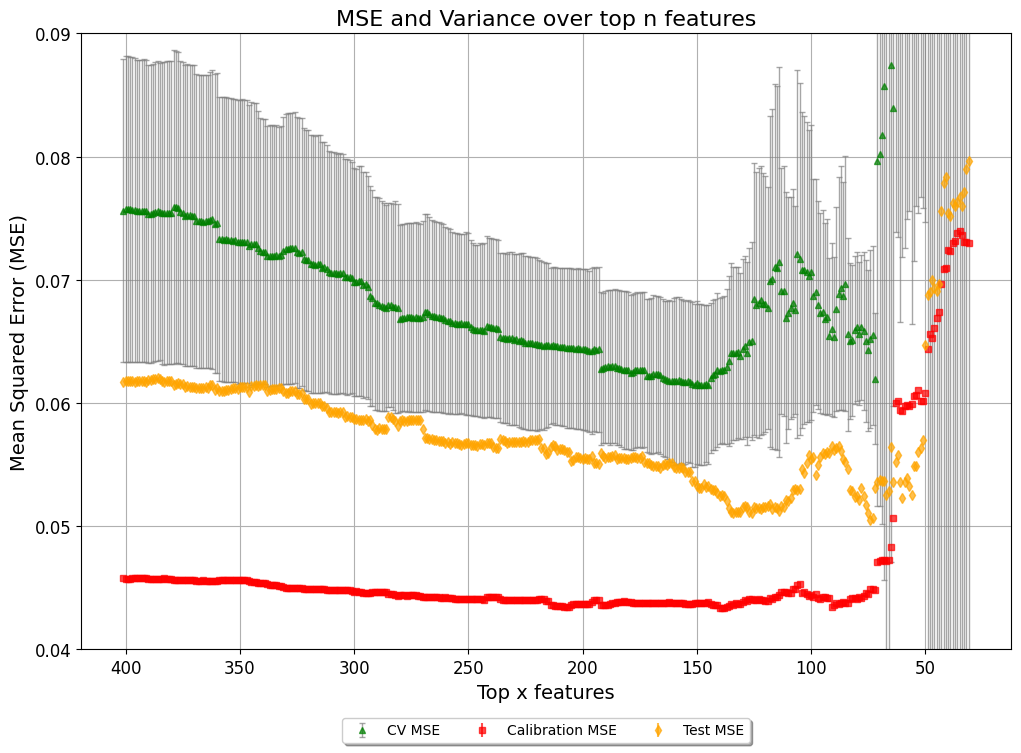

In [108]:
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['val mse'][::-1], yerr=table['val std'][::-1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration mse'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test mse'][::-1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.04,0.09)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

In [114]:
pls=PLSRegression(n_components=15)
pls.fit(x_train,y_train)
results = permutation_importance(pls,
                                x_train,
                                y_train,
                                )
a=pd.Series(results.importances_mean).rank(ascending=False)
a=a.sort_values()

In [145]:
a=perm_imp_get_topn_indexes(a,100)
spectra=pd.Series(range(401))
spectra=spectra.isin(a).astype(int)

TypeError: xlabel() missing 1 required positional argument: 'xlabel'

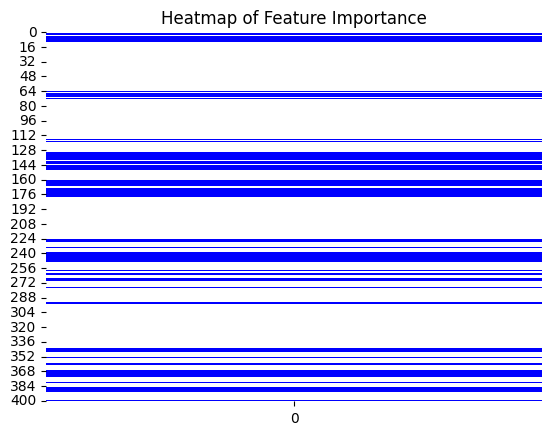

In [157]:
cmap = ListedColormap(['none', 'blue'])  # 'none' is transparent

# Create the heatmap
#plt.figure(figsize=(10, 10))
sns.heatmap(spectra.values.reshape(-1,1), annot=False, cmap=cmap, cbar=False)  # cbar=False disables the color bar

plt.title('Heatmap of Feature Importance')
plt.ylabel('Wave number')
plt.show()

##### mrmr pls

In [256]:
def build_table_pls_mrmr(x_train,y_train,x_test,y_test,step,k_folds,latent_variables):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    selected_features=mrmr_regression(X=x_train,
                                  y=y_train,
                                  K=401)
    
    for features in np.arange(401,30,-step):
        
        important_idx=selected_features[0:features]
    
        x_train=x_train[important_idx]
        x_test=x_test[important_idx]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            pls=PLSRegression(n_components=latent_variables)
            pls.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,pls.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,pls.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        

        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train,y_train)
        
        train_loss=mean_squared_error(y_train,pls.predict(x_train))
        test_loss=mean_squared_error(y_test,pls.predict(x_test))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss]
            
    return stored

In [257]:
#this code yielded me exactly the same values the library returned.
'''
import pandas as pd
from sklearn.feature_selection import f_regression
def custom_mrmr(X,y,K):
    # inputs:
    #    X: pandas.DataFrame, features
    #    y: pandas.Series, target variable
    #    K: number of features to select

    # compute F-statistics and correlations
    F = pd.Series(f_regression(X, y)[0], index = X.columns)
    corr = X.corr().abs().clip(.00001) # minimum value of correlation set to .00001 (to avoid division by zero)

    # initialize list of selected features and list of excluded features
    selected = []
    not_selected = list(X.columns)

    # repeat K times: 
    # compute FCQ score for all the features that are currently excluded,
    # then find the best one, add it to selected, and remove it from not_selected
    for i in range(K):
        
        # compute FCQ score for all the (currently) excluded features (this is Formula 2)
        score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
        
        # find best feature, add it to selected and remove it from not_selected
        best = score.index[score.argmax()]
        selected.append(best)
        not_selected.remove(best)
    return selected
    '''

In [283]:
table = build_table_pls_mrmr(x_train=x_train,
                             y_train=y_train,
                             x_test=x_test,
                             y_test=y_test,  
                             step=1,
                             k_folds=5,
                             latent_variables=20)

100%|██████████| 401/401 [00:18<00:00, 21.39it/s]


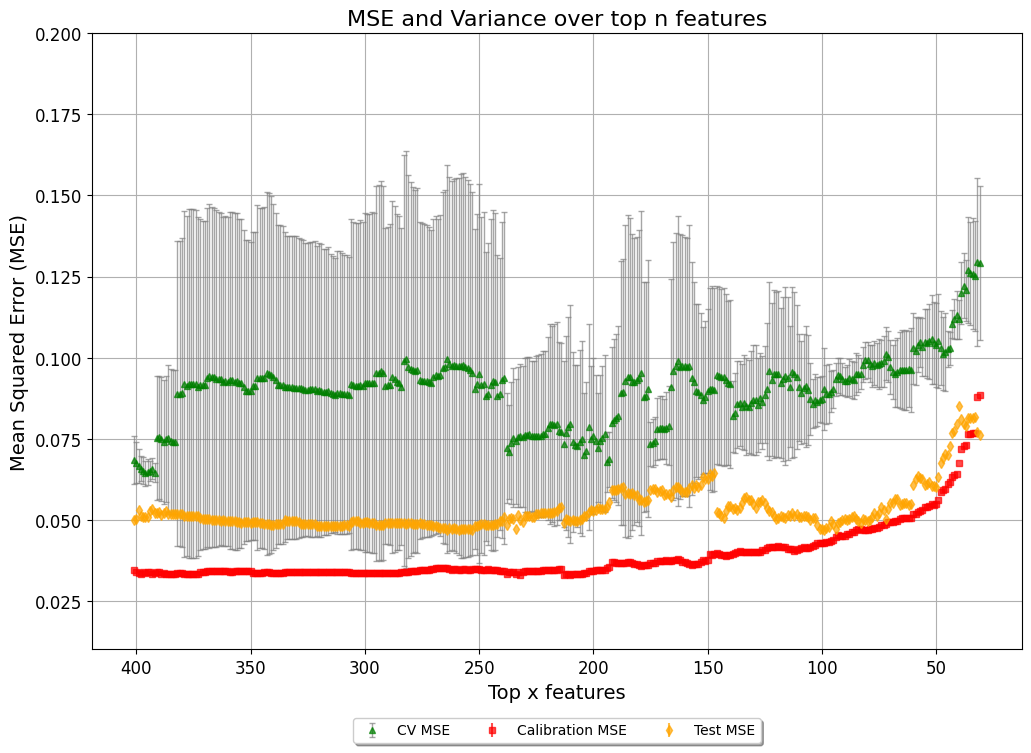

In [285]:
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['val mse'][::-1], yerr=table['val std'][::-1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration mse'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test mse'][::-1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.01,0.2)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

##### just troubleshooting...1 function NN

In [ ]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_pls(X_train,y_train,k_folds):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((x_train.shape[1],kfold.n_splits))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        pls=MLPRegressor(hidden_layer_sizes=(2),activation='tanh',solver='adam')
        pls.fit(x_train_fold,y_train_fold)
        
        results = permutation_importance(pls,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances

In [ ]:
def build_table_pls(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds,latent_variables):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    for features in np.arange(401,30,-step):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train=x_train[important_idx.sort_values()]
        x_test=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            pls=PLSRegression(n_components=latent_variables)
            pls.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,pls.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,pls.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        

        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train,y_train)
        
        train_loss=mean_squared_error(y_train,pls.predict(x_train))
        test_loss=mean_squared_error(y_test,pls.predict(x_test))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss]
            
    return stored

##### Just troubleshooting 2